In [168]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from ast import literal_eval  

Read data

In [169]:
data="data.json"
with open(data,'r') as file:
  data=json.load(file)

In [170]:
stocktrain=data['ACB']

In [171]:
def convert_str_to_float(str_num):
    return float(str_num.replace(',', ''))

data_dict = {key: literal_eval(value) for key, value in stocktrain.items()}
df = pd.DataFrame.from_dict(data_dict, orient='index')
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')
df = df.map(convert_str_to_float)
df=df.sort_index(ascending=True)

print(df)


               open     high      low    close      volume
2021-11-09  22320.0  22587.0  22286.0  22353.0   6598500.0
2021-11-10  22386.0  22420.0  22152.0  22320.0   5794500.0
2021-11-11  22253.0  22420.0  21718.0  22052.0   7503700.0
2021-11-12  22052.0  22286.0  21818.0  22286.0  17087412.0
2021-11-15  22320.0  22453.0  22219.0  22320.0   5435700.0
...             ...      ...      ...      ...         ...
2024-02-16  27500.0  27600.0  27300.0  27600.0   9495400.0
2024-02-19  27700.0  27700.0  27200.0  27700.0  11856900.0
2024-02-20  27500.0  27750.0  27350.0  27550.0   7316400.0
2024-02-21  27500.0  27900.0  27400.0  27700.0  10251900.0
2024-02-22  27700.0  27750.0  27500.0  27650.0   7401800.0

[570 rows x 5 columns]


In [172]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 570 entries, 2021-11-09 to 2024-02-22
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    570 non-null    float64
 1   high    570 non-null    float64
 2   low     570 non-null    float64
 3   close   570 non-null    float64
 4   volume  570 non-null    float64
dtypes: float64(5)
memory usage: 26.7 KB
None
               open          high           low         close        volume
count    570.000000    570.000000    570.000000    570.000000  5.700000e+02
mean   21345.387719  21573.343860  21111.891228  21331.980702  6.457273e+06
std     1994.071256   1970.326041   2031.899244   2009.391929  4.683361e+06
min    14952.000000  15620.000000  14576.000000  14618.000000  7.580000e+05
25%    20382.000000  20549.000000  20131.000000  20262.250000  3.370840e+06
50%    21600.000000  21750.000000  21325.000000  21600.000000  5.255700e+06
75%    22386.000000  22550.000000  22152

Data visualization

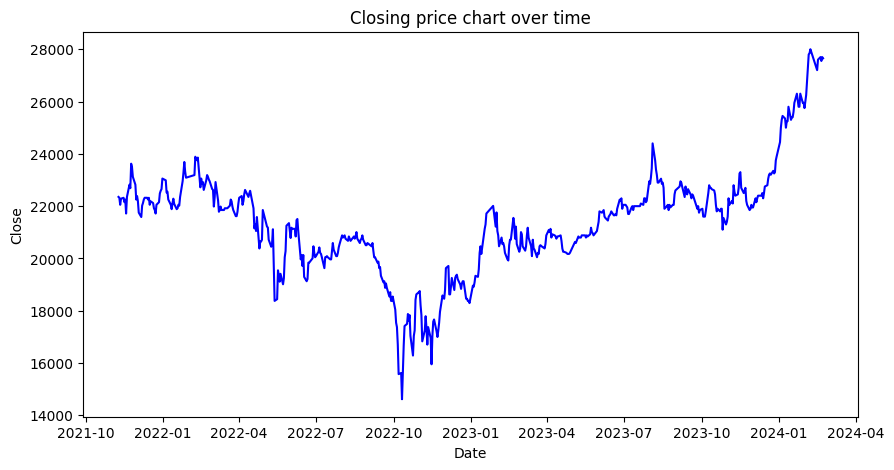

In [173]:
fig, axes = plt.subplots(figsize=(10, 5))
sns.lineplot(x=df.index, y='close', data=df, ax=axes, color='blue')
axes.set_title('Closing price chart over time')
axes.set_xlabel('Date')
axes.set_ylabel('Close')
plt.show()

Data processing

In [174]:
dataema=df.copy()
dataema['ema_point'] = 0  
dataema['EMA5'] = dataema.close.ewm(span=5, adjust=False).mean()
dataema['EMA20'] = dataema.close.ewm(span=20, adjust=False).mean()
dataema['EMA50'] = dataema.close.ewm(span=50, adjust=False).mean()
dataema['EMA75'] = dataema.close.ewm(span=75, adjust=False).mean()


dataema.loc[(dataema['EMA5'] < dataema['EMA20']) & (dataema['EMA5'].shift(1) >= dataema['EMA20'].shift(1)), 'ema_point'] = 1
dataema.loc[(dataema['EMA5'] > dataema['EMA20']) & (dataema['EMA5'].shift(1) <= dataema['EMA20'].shift(1)), 'ema_point'] = -1

dataema.loc[(dataema['EMA20'] < dataema['EMA50']) & (dataema['EMA20'].shift(1) >= dataema['EMA50'].shift(1)), 'ema_point'] = 1
dataema.loc[(dataema['EMA20'] > dataema['EMA50']) & (dataema['EMA20'].shift(1) <= dataema['EMA50'].shift(1)), 'ema_point'] = -1
df['ema_point']=dataema['ema_point']

print(df)

               open     high      low    close      volume  ema_point
2021-11-09  22320.0  22587.0  22286.0  22353.0   6598500.0          0
2021-11-10  22386.0  22420.0  22152.0  22320.0   5794500.0          1
2021-11-11  22253.0  22420.0  21718.0  22052.0   7503700.0          0
2021-11-12  22052.0  22286.0  21818.0  22286.0  17087412.0          0
2021-11-15  22320.0  22453.0  22219.0  22320.0   5435700.0          0
...             ...      ...      ...      ...         ...        ...
2024-02-16  27500.0  27600.0  27300.0  27600.0   9495400.0          0
2024-02-19  27700.0  27700.0  27200.0  27700.0  11856900.0          0
2024-02-20  27500.0  27750.0  27350.0  27550.0   7316400.0          0
2024-02-21  27500.0  27900.0  27400.0  27700.0  10251900.0          0
2024-02-22  27700.0  27750.0  27500.0  27650.0   7401800.0          0

[570 rows x 6 columns]


In [175]:
import plotly.graph_objects as go
import plotly.io as pio
fig = go.Figure(data=[
    go.Ohlc(x=dataema.index,
            open=dataema['open'],
            high=dataema['high'],
            low=dataema['low'],
            close=dataema['close'], name="OHLC"),
    go.Scatter(x=dataema.index, y=dataema['EMA5'], line=dict(color='orange', width=1), name="EMA5"),
    go.Scatter(x=dataema.index, y=dataema['EMA20'], line=dict(color='green', width=1), name="EMA20"),
    go.Scatter(x=dataema.index, y=dataema['EMA50'], line=dict(color='blue', width=1), name="EMA50"),
])
pio.show(fig)

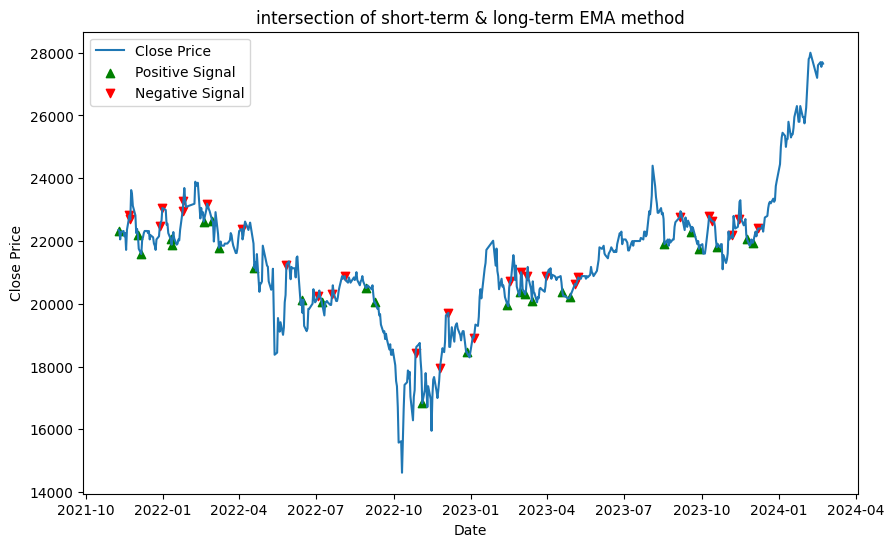

In [176]:

plt.figure(figsize=(10, 6))
plt.plot(df['close'], label='Close Price')
buy_signals = df[df['ema_point'] == 1]
sell_signals = df[df['ema_point'] == -1]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', label='Positive Signal')
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', label='Negative Signal')
plt.title('intersection of short-term & long-term EMA method')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [177]:
def cusum_filter(dataset, threshold):
    pos_dates, neg_dates = [], []
    pos_sum, neg_sum = 0, 0
    dataset['differences'] = dataset['close'].diff()
    for i, r in dataset.iloc[1:].iterrows():
        pos_sum = max(0, pos_sum + r['differences'])
        neg_sum = min(0, neg_sum + r['differences'])
        if pos_sum > threshold:
            pos_sum = 0  # Reset
            pos_dates.append(i)
        elif neg_sum < -threshold:
            neg_sum = 0  # Reset
            neg_dates.append(i)
    return pos_dates, neg_dates

<Axes: >

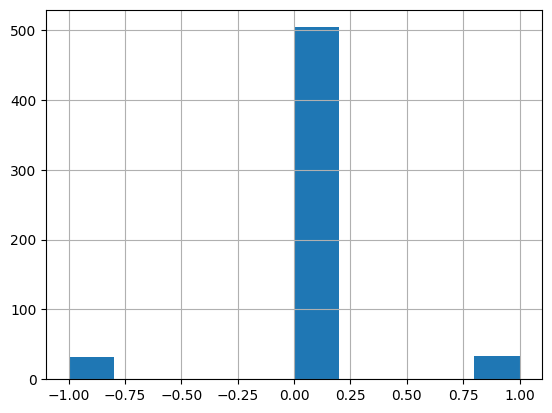

In [178]:
#creature feature cusum_point
threshold_value = 1000
dataframe=df
positive_dates, negative_dates = cusum_filter(dataframe, threshold_value)
df['cusum_point']=0
df.loc[df.index.isin(positive_dates), 'cusum_point'] = 1
df.loc[df.index.isin(negative_dates), 'cusum_point'] = -1
df["cusum_point"].hist()

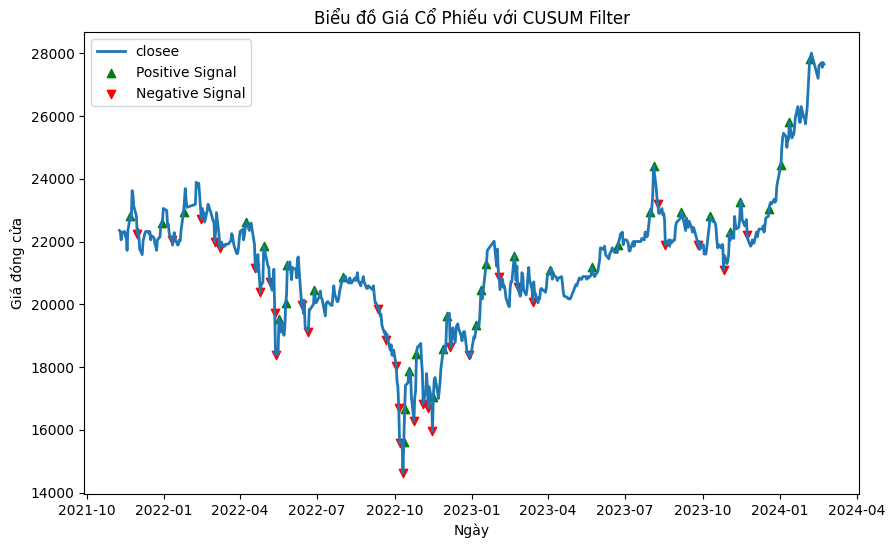

In [179]:
plt.figure(figsize=(10, 6))
plt.plot(dataframe.index, dataframe['close'], label='closee', linewidth=2)
plt.scatter(positive_dates, dataframe['close'].loc[positive_dates], marker='^', color='g', label='Positive Signal')
plt.scatter(negative_dates, dataframe['close'].loc[negative_dates], marker='v', color='r', label='Negative Signal')
plt.title('Biểu đồ Giá Cổ Phiếu với CUSUM Filter')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.show()

Sử dụng biểu đồ CUSUM :
Khi tích lũy dương vượt ngưỡng dương thì sẽ có xu hướng tăng:nên mua
Khi tích lũy âm vượt ngưỡng âm thì sẽ có xu hướng giảm:nên bán

In [180]:
import numpy as np
def detect_peaks(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filtered_y = np.copy(y)  
    avg_filter = np.mean(y[:lag])
    std_filter = np.std(y[:lag])

    for i in range(lag, len(y)):
        if np.abs(y[i] - avg_filter) > threshold * std_filter:
            if y[i] > avg_filter:
                signals[i] = 1  # Positive signal
            else:
                signals[i] = -1  # Negative signal
            if i < len(y) - 1:
                filtered_y[i+1] = influence * y[i+1] + (1 - influence) * filtered_y[i]
        else:
            signals[i] = 0  # No signal
            if i < len(y) - 1:
                filtered_y[i+1] = y[i+1]

        avg_filter = np.mean(filtered_y[max(i-lag+1, 0):i+1])
        std_filter = np.std(filtered_y[max(i-lag+1, 0):i+1])

    return signals

C:\Users\GIANG\AppData\Local\Temp\ipykernel_11272\4177896946.py:9: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\GIANG\AppData\Local\Temp\ipykernel_11272\4177896946.py:19: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\GIANG\AppData\Local\Temp\ipykernel_11272\4177896946.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\GIANG\AppData\Local\Temp\ipykernel_11272\4177896946.py:15: FutureWarning:

Series.__ge

<Axes: >

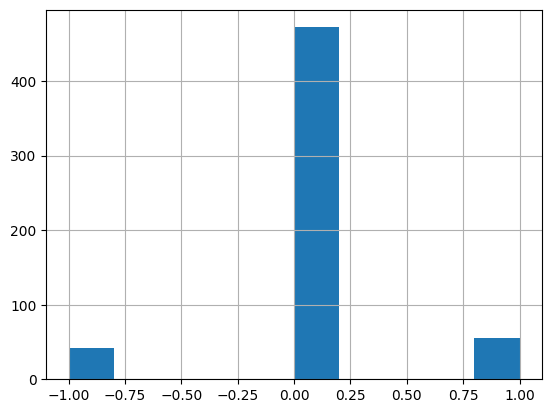

In [181]:
lag = 10
threshold = 2.5
influence = 0.3
df['peak_point'] = detect_peaks(df['close'], lag, threshold, influence)
df['peak_point'].hist()

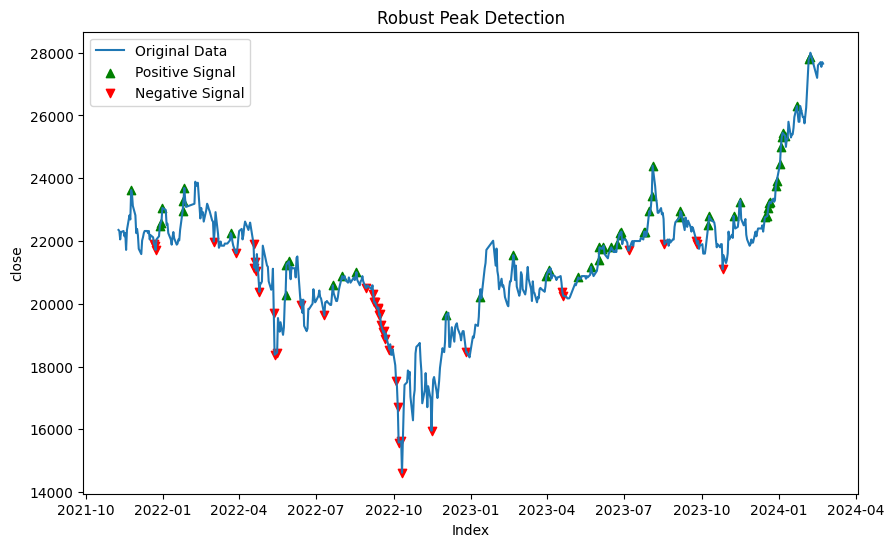

In [182]:
# Trực quan hóa
plt.figure(figsize=(10, 6))
plt.plot(df['close'], label='Original Data')
plt.scatter(df.index[df['peak_point'] == 1], df['close'][df['peak_point'] == 1], color='green', label='Positive Signal', marker='^')
plt.scatter(df.index[df['peak_point'] == -1], df['close'][df['peak_point'] == -1], color='red', label='Negative Signal', marker='v')
plt.title('Robust Peak Detection')
plt.xlabel('Index')
plt.ylabel('close')
plt.legend()
plt.show()

 nếu một điểm dữ liệu mới có x số độ lệch chuẩn nhất định so với giá trị trung bình động,thì đánh dấu điểm đó .

In [183]:
df.reset_index(inplace=True)
df.rename(columns={'index': 'date'}, inplace=True)

In [184]:
data_copy=df.copy()
data_copy

,date,open,high,low,close,volume,ema_point,differences,cusum_point,peak_point
0,2021-11-09,22320.0,22587.0,22286.0,22353.0,6598500.0,0,NaN,0,0.0
1,2021-11-10,22386.0,22420.0,22152.0,22320.0,5794500.0,1,-33.0,0,0.0
2,2021-11-11,22253.0,22420.0,21718.0,22052.0,7503700.0,0,-268.0,0,0.0
3,2021-11-12,22052.0,22286.0,21818.0,22286.0,17087412.0,0,234.0,0,0.0
4,2021-11-15,22320.0,22453.0,22219.0,22320.0,5435700.0,0,34.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
565,2024-02-16,27500.0,27600.0,27300.0,27600.0,9495400.0,0,400.0,0,0.0
566,2024-02-19,27700.0,27700.0,27200.0,27700.0,11856900.0,0,100.0,0,0.0
567,2024-02-20,27500.0,27750.0,27350.0,27550.0,7316400.0,0,-150.0,0,0.0
568,2024-02-21,27500.0,27900.0,27400.0,27700.0,10251900.0,0,150.0,0,0.0


In [185]:
def label_tripple_barrier_method(data, length):
    data['tri_barr_point'] = 0  
    for i in range(length, len(data)-1):
        volatility = data['close'].iloc[i-length:i].std()
    
        upper_barrier = data['close'].iloc[i] + volatility
        lower_barrier = data['close'].iloc[i] - volatility
  
        if data.iloc[i+1,4] > upper_barrier:
            data.loc[i, 'tri_barr_point'] = 1 
        elif data.iloc[i+1,4] < lower_barrier:
            data.loc[i, 'tri_barr_point'] = -1
    return data

In [186]:
data_label=label_tripple_barrier_method(data_copy,20)

<Axes: >

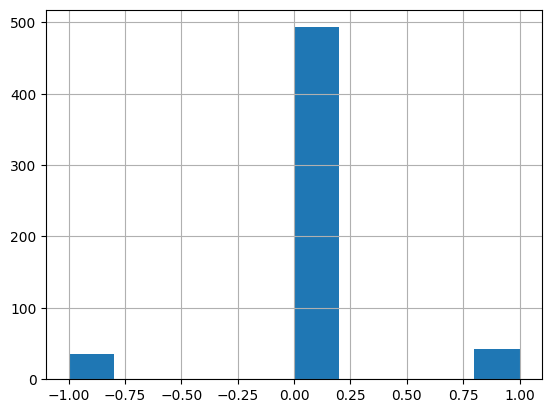

In [187]:
data_label['tri_barr_point'].hist()

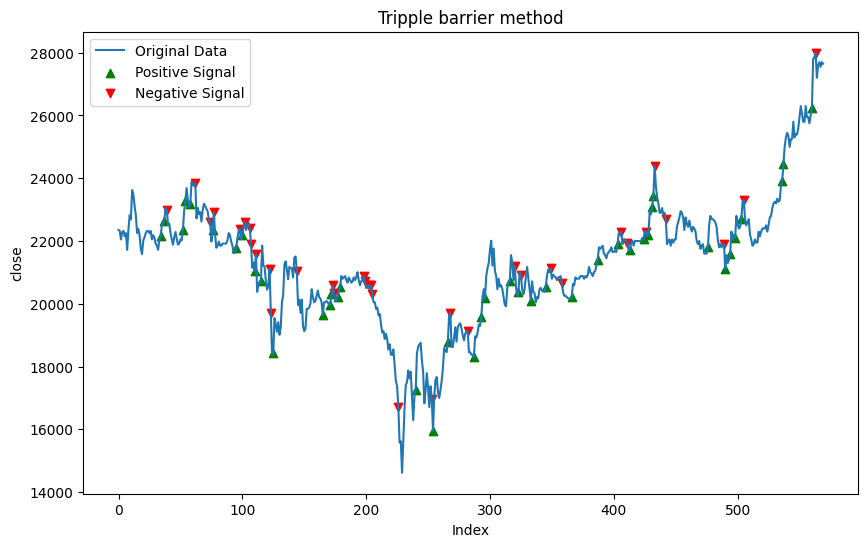

In [188]:
plt.figure(figsize=(10, 6))
plt.plot(data_label['close'], label='Original Data')
plt.scatter(data_label.index[data_label['tri_barr_point'] == 1], data_label['close'][data_label['tri_barr_point'] == 1], color='green', label='Positive Signal', marker='^')
plt.scatter(data_label.index[data_label['tri_barr_point'] == -1], data_label['close'][data_label['tri_barr_point'] == -1], color='red', label='Negative Signal', marker='v')
plt.title('Tripple barrier method')
plt.xlabel('Index')
plt.ylabel('close')
plt.legend()
plt.show()

<Axes: >

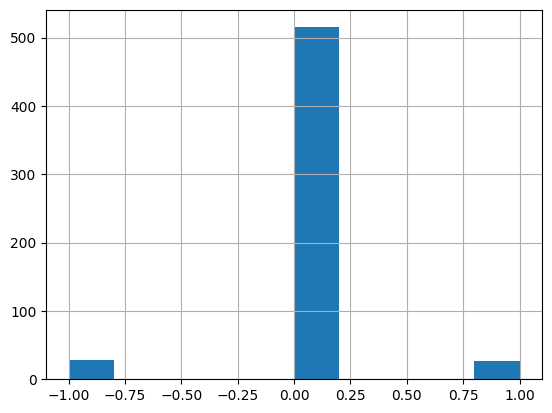

In [189]:
df['ema_point'].hist()

In [190]:
data_label.head(21)

,date,open,high,low,close,volume,ema_point,differences,cusum_point,peak_point,tri_barr_point
0,2021-11-09,22320.0,22587.0,22286.0,22353.0,6598500.0,0,NaN,0,0.0,0
1,2021-11-10,22386.0,22420.0,22152.0,22320.0,5794500.0,1,-33.0,0,0.0,0
2,2021-11-11,22253.0,22420.0,21718.0,22052.0,7503700.0,0,-268.0,0,0.0,0
3,2021-11-12,22052.0,22286.0,21818.0,22286.0,17087412.0,0,234.0,0,0.0,0
4,2021-11-15,22320.0,22453.0,22219.0,22320.0,5435700.0,0,34.0,0,0.0,0
5,2021-11-16,22286.0,22320.0,21919.0,22152.0,5261500.0,0,-168.0,0,0.0,0
6,2021-11-17,22152.0,22386.0,21919.0,22253.0,5060500.0,0,101.0,0,0.0,0
7,2021-11-18,22386.0,22386.0,21718.0,21718.0,5497600.0,0,-535.0,0,0.0,0
8,2021-11-19,21852.0,22654.0,21752.0,22353.0,10217500.0,0,635.0,0,0.0,0
9,2021-11-22,22386.0,23255.0,22052.0,22821.0,9493900.0,-1,468.0,1,0.0,0


Training

In [191]:
# def combine_labels(row):
#     if row.sum() >= 1:
#         return 1
#     elif row.sum() <= -1:
#         return -1
#     else:
#         return 0

In [192]:
# import numpy as np
# from sklearn.preprocessing import OneHotEncoder

# def create_training_data(df, label, window,selected_features):
#     """
#     Tạo dữ liệu huấn luyện từ dữ liệu chuỗi thời gian.
#     Parameters:
#     - df (pd.DataFrame): DataFrame chứa dữ liệu chuỗi thời gian.
#     - label (str): Tên cột chứa nhãn.
#     - window (int): Kích thước cửa sổ trượt.

#     Returns:
#     - X (np.array): Ma trận chứa các cửa sổ dữ liệu.
#     - y (np.array): Mảng chứa nhãn tương ứng với mỗi cửa sổ.
#     """
#     X = []
#     y = []

#     for i in range(len(df) - window):
#         window_data = df[selected_features].iloc[i:i + window] 
#         window_label = df[label].iloc[i + window]  

#         X.append(window_data.values)
#         y.append(window_label)

#     X = np.array(X)
#     y = np.array(y)

#     return X, y




In [193]:
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.model_selection import train_test_split
# from sklearn import svm
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report


# selected_features = ['open', 'high', 'low', 'close', 'volume']
# label_combine_feature = ['ema_point', 'cusum_point', 'peak_point', 'tri_barr_point']

# data_label['combined_label'] = data_label[label_combine_feature].apply(combine_labels, axis=1)

# train_size = int(len(data_label) * 0.8)
# train_data = data_label.iloc[:train_size]
# test_data = data_label.iloc[train_size:]
# window = 20
# X_train, y_train = create_training_data(train_data, 'combined_label', window, selected_features)
# X_test, y_test = create_training_data(test_data, 'combined_label', window, selected_features)
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.fit_transform(y_test)
# X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
#     X_train, y_train_encoded, test_size=0.2, random_state=42
# )


In [194]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# X_train_split_scaled = scaler.fit_transform(X_train_split.reshape(-1, X_train_split.shape[-1])).reshape(X_train_split.shape)
# X_test_split_scaled = scaler.transform(X_test_split.reshape(-1, X_test_split.shape[-1])).reshape(X_test_split.shape)
# X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)



In [195]:
# X_train_split_scaled.shape


In [196]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense
# model = Sequential()
# model.add(LSTM(50, input_shape=(X_train_split_scaled.shape[1], X_train_split_scaled.shape[2])))
# model.add(Dense(1, activation='softmax'))  
# # Biên soạn và đào tạo mô hình
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(X_train_split_scaled, y_train_split, epochs=10, batch_size=32, validation_data=(X_test_split_scaled, y_test_split))

# y_probabilities = model.predict(X_test_scaled)
# print(f'Accuracy on validation set: ',y_probabilities)

In [197]:

# param_grid = {'C': [0.1, 1,10,100], 'kernel': ['linear', 'rbf'], 'gamma': [0.01, 0.1,1,10]}
# grid_search = GridSearchCV(svm.SVC(), param_grid, cv=5)
# grid_search.fit(X_train_split_scaled.reshape(X_train_split_scaled.shape[0], -1), y_train_split) 

# # Reshape the test set similarly
# X_test_split_scaled_flat = X_test_split_scaled.reshape(X_test_split_scaled.shape[0], -1)

# y_pred = grid_search.predict(X_test_split_scaled_flat)

In [198]:
# y_pred

In [199]:
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, classification_report
# dtrain = xgb.DMatrix(X_train_split_scaled, label=y_train_split.argmax(axis=1))
# dtest = xgb.DMatrix(X_test_split_scaled, label=y_test_split.argmax(axis=1))

# # Define hyperparameters
# params = {
#     'objective': 'multi:softmax',  # for multi-class classification
#     'num_class': len(np.unique(y_train)),  # number of classes
#     'eval_metric': 'mlogloss',  # log-likelihood loss for multi-class
#     'eta': 0.1,  # learning rate
#     'max_depth': 6,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8
# }

# # Train the XGBoost model
# num_round = 100  # number of boosting rounds
# bst = xgb.train(params, dtrain, num_round)

# # Make predictions on the test set
# y_pred = bst.predict(dtest)

# # # Evaluate the model
# # accuracy = accuracy_score(y_test.argmax(axis=1), y_pred)
# # classification_report_result = classification_report(y_test.argmax(axis=1), y_pred)

# # print(f"Accuracy: {accuracy}")
# # print("Classification Report:")
# # print(classification_report_result)

In [200]:
# import numpy as np
# from sklearn import svm
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import classification_report
# from sklearn.preprocessing import OneHotEncoder
# X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
# encoder = OneHotEncoder(categories='auto')
# y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))

# X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_reshaped, y_train_onehot, test_size=0.2, random_state=42)


# param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': [0.01, 0.1, 1, 'auto']}
# grid_search = GridSearchCV(svm.SVC(), param_grid, cv=5)
# grid_search.fit(X_train_split, y_train_split)

# # Dự đoán trên tập kiểm thử với tham số tối ưu
# y_pred = grid_search.predict(X_test_split)

# # Đánh giá mô hình
# print("Classification Report:")
# print(classification_report(y_test_split.argmax(axis=1), y_pred.argmax(axis=1)))

In [201]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Input

# # Tạo mô hình LSTM
# model = Sequential()
# model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
# model.add(Dense(1, activation='softmax')) 

# # Biên dịch mô hình
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# # Huấn luyện mô hình
# history = model.fit(
#     X_train_scaled,  # Dữ liệu đã được chuẩn hóa
#     y_train_reshaped,
#     epochs=10,
#     batch_size=32,
#     validation_data=(X_test_scaled, y_test_reshaped),
# )

# # Đánh giá mô hình trên tập kiểm thử
# eval_result = model.evaluate(X_test_scaled, y_test)
# print(f"Accuracy on test set: {eval_result[1]*100:.2f}%")


In [202]:
# from sklearn.metrics import confusion_matrix
# y_pred= model.predict(X_test)

# # Chuyển đổi one-hot encoding về dạng số nguyên
# y_pred = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_test, axis=1)

# # Tính ma trận nhầm lẫn
# conf_matrix = confusion_matrix(y_true, y_pred)
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.show()


